<a href="https://colab.research.google.com/github/lorenzogiarnese/forecasting-volatility-as-a-service/blob/main/volatility_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install --upgrade arch

In [ ]:
!pip install pmdarima

In [ ]:
 !pip3 install yfinance

In [ ]:
!pip install optuna

In [ ]:
!pip install statsforecast

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import optuna
from statsforecast.models import RandomWalkWithDrift
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error as mse
from scipy import stats
from scipy.interpolate import interp1d


%matplotlib inline

In [ ]:
import yfinance as yf

from datetime import datetime

#**Parameters selection**

In [ ]:
#define validation and test dataset percentage
validation_percentage = 20
test_percentage = 10

In [ ]:
INTERVAL_WINDOW = 30

In [ ]:
#set number of periods about which receiving forecast
n_future = 7

By setting the `INTERVAL_WINDOW `to 30, it means calculating the volatility over a 30-day time window. This value is derived from practical experiments, it is shown that the `INTERVAL_WINDOW` equal to 30 provides a good granularity.

The positive aspect of calculating volatility over a restricted time window like the `INTERVAL_WINDOW` is that it can provide a more sensitive and up-to-date measure of return variability in the short term. Some of the advantages include:

* Sensitivity to recent changes: By using a restricted time window, volatility will be primarily influenced by the most recent returns. This can be useful in quickly capturing volatility changes in the short term, such as during periods of high uncertainty or significant news that can impact asset prices.
* Adaptability to changing market conditions: Financial markets can experience significant and sudden changes in conditions. By using a restricted time window, the volatility calculation will be more responsive to these changes, allowing for faster identification of periods of higher volatility or changes in price dynamics.
* Response to seasonal or cyclical events: If there are seasonal or cyclical patterns in asset returns, using a restricted time window can help capture these fluctuations in the short term. For example, there may be increased volatility during holiday periods or during the sales season.
However, it's important to consider that a broader time window can provide a more comprehensive and stable view of long-term volatility. Therefore, the use of a restricted time window like the `INTERVAL_WINDOW` is a choice that depends on the specific context of the analysis and the objectives of the investor or researcher.





Here are some approximations for common time intervals:

-> **7 days (1 week)**: Set forecast_horizon to 5 (assuming a 5-day trading week).

-> **30 days (1 month)**: Set forecast_horizon to approximately 20 (considering an average of 20 trading days in a month).

-> **90 days (3 months)**: Set forecast_horizon to around 60 (based on approximately 60 trading days in 3 months).

-> **150 days (5 months)**: Set forecast_horizon to roughly 100 (considering an average of 20 trading days per month).

In [ ]:
"""def switch(n_future):
  match (n_future):
    case 7:
      return 5
    case 30:
      return 20
    case 90:
      return 60
    case 150:
      return 100"""


'def switch(n_future):\n  match (n_future):\n    case 7:\n      return 5\n    case 30:\n      return 20\n    case 90:\n      return 60\n    case 150:\n      return 100'

In [ ]:
#horizon = switch(n_future)
horizon = n_future

#**Data Preparation and Data Exploration**

* Start with a time series dataset of one financial asset.
* Implement time-based interpolation using spline interpolation in order to deal with missing values in the dataset.
* Calulate returns as daily percentage change using the function 'pct_change()'.
* Calculate log returns.



In [ ]:
tckr = "AAPL"

"""with open('jobname', 'r') as f:
  tckr = f.read()
"""
ticker = yf.Ticker(tckr)

start = datetime(2014, 1, 1)
end = datetime(2023,6,1)

df = ticker.history(start=start, end=end, interval="1d")

In [ ]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [ ]:
print(df)
# Salviamo il DataFrame come file CSV
df.to_csv('mio_file.csv')

                                 Open        High         Low       Close  \
Date                                                                        
2014-01-02 00:00:00-05:00   17.421491   17.463815   17.306743   17.341543   
2014-01-03 00:00:00-05:00   17.333085   17.359419   16.943382   16.960627   
2014-01-06 00:00:00-05:00   16.849950   17.143087   16.729245   17.053108   
2014-01-07 00:00:00-05:00   17.065339   17.116755   16.864689   16.931154   
2014-01-08 00:00:00-05:00   16.892591   17.104215   16.888831   17.038378   
...                               ...         ...         ...         ...   
2023-05-24 00:00:00-04:00  170.859273  172.187481  170.290049  171.608261   
2023-05-25 00:00:00-04:00  172.177494  173.665475  171.458464  172.756714   
2023-05-26 00:00:00-04:00  173.086280  175.532973  172.876557  175.193420   
2023-05-30 00:00:00-04:00  176.721360  178.748621  176.331887  177.060898   
2023-05-31 00:00:00-04:00  177.090865  179.108145  176.521626  177.010971   

In [ ]:
# Create a mask for missing values
mask = df.isnull()

# Iterate over the columns to apply time-based interpolation
for column in df.columns:
    # Skip columns that don't have missing values
    if not mask[column].any():
        continue

    # Create a Series of time values corresponding to the missing values
    time_values = pd.to_numeric(df[mask[column]].index)

    # Create a Series of observed values without missing values
    observed_values = df.loc[~mask[column], column]

    # Perform spline interpolation
    interpolated_values = interp1d(pd.to_numeric(df.loc[~mask[column]].index), observed_values, kind='cubic')(time_values)

    # Update the DataFrame with interpolated values
    df.loc[mask[column], column] = interpolated_values

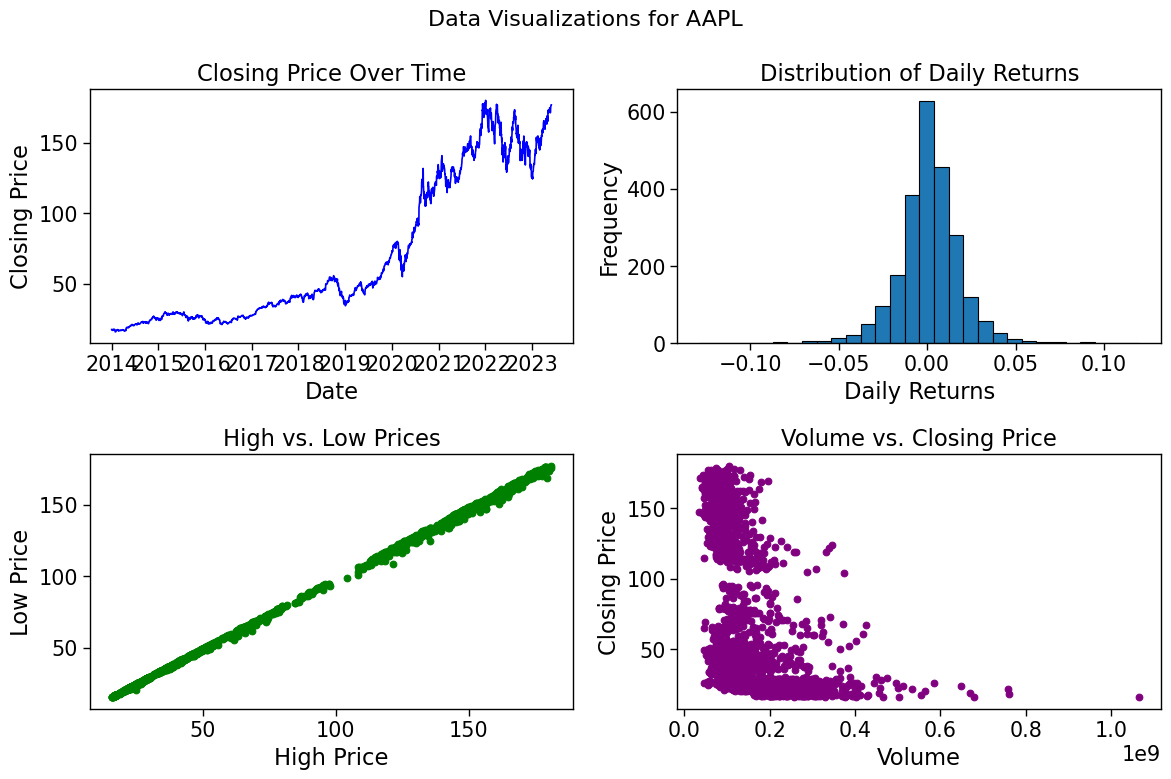

In [ ]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Data Visualizations for {}'.format(tckr), fontsize=16)

# Line Graph - Volatility Over Time
axs[0, 0].plot(df['Close'], color='blue')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Closing Price')
axs[0, 0].set_title('Closing Price Over Time')

# Histogram - Daily Returns
axs[0, 1].hist(df['Close'].pct_change(), bins=30, edgecolor='black')
axs[0, 1].set_xlabel('Daily Returns')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Distribution of Daily Returns')

# Scatter Plot - High vs. Low Prices
axs[1, 0].scatter(df['High'], df['Low'], color='green')
axs[1, 0].set_xlabel('High Price')
axs[1, 0].set_ylabel('Low Price')
axs[1, 0].set_title('High vs. Low Prices')

# Scatter Plot - Volume vs. Close Price
axs[1, 1].scatter(df['Volume'], df['Close'], color='purple')
axs[1, 1].set_xlabel('Volume')
axs[1, 1].set_ylabel('Closing Price')
axs[1, 1].set_title('Volume vs. Closing Price')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

**Volatility:** Volatility measures the degree of variation or dispersion of returns. It quantifies the level of uncertainty or risk associated with an asset's price movements. Volatility is typically calculated as the standard deviation or variance of returns. Higher volatility indicates larger price fluctuations, which implies greater risk.

**Volatility and returns:** Volatility is a measure of the dispersion of returns. Higher volatility indicates a wider range of returns, indicating greater uncertainty or risk. Volatility is commonly used to assess the risk associated with an asset or portfolio.

**Volatility and log returns:** Volatility is typically calculated based on log returns rather than simple returns. This is because log returns have better statistical properties for modeling and analysis. The volatility calculated using log returns is often referred to as historical volatility or realized volatility.

In [ ]:
#calculate price returns as daily percentage using pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

#df.Close.shift(1) è la riga successiva della colonna che rappresenta il prezzo di chiusura del giorno successivo
df['log_returns'] = np.log(df.Close/df.Close.shift(1)).dropna()

In [ ]:
#devo droppare la prima riga perchè il valore pt-1 non esiste
df.drop(df.index[0], inplace=True)
df.dropna(inplace=True)
df.describe()

,Open,High,Low,Close,Volume,returns,log_returns
count,2368.000000,2368.000000,2368.000000,2368.000000,2.368000e+03,2368.000000,2368.000000
mean,69.350586,70.140021,68.607415,69.409281,1.416086e+08,0.114710,0.000981
std,51.471403,52.132832,50.856130,51.527112,8.400694e+07,1.819708,0.018203
min,15.524712,15.723795,15.473609,15.668934,3.519590e+07,-12.864696,-0.137708
25%,26.799410,27.068254,26.604446,26.898584,8.604020e+07,-0.720694,-0.007233
50%,44.221497,44.523339,43.823038,44.228100,1.167480e+08,0.090326,0.000903
75%,123.051826,124.621039,121.659694,123.378130,1.724382e+08,1.034573,0.010293
max,180.804793,181.111693,177.329863,180.190948,1.065523e+09,11.980846,0.113158


In [ ]:
def split_dataset(dataframe, validation_percentage, test_percentage):
    dataset_size = len(dataframe)

    # Calcola le dimensioni dei set in base alle percentuali fornite
    val_size = int(dataset_size * validation_percentage / 100)
    test_size = int(dataset_size * test_percentage / 100)
    train_size = dataset_size - val_size - test_size


    return val_size, test_size, train_size

<ipython-input-113-533f47521d35>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
<ipython-input-113-533f47521d35>:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',


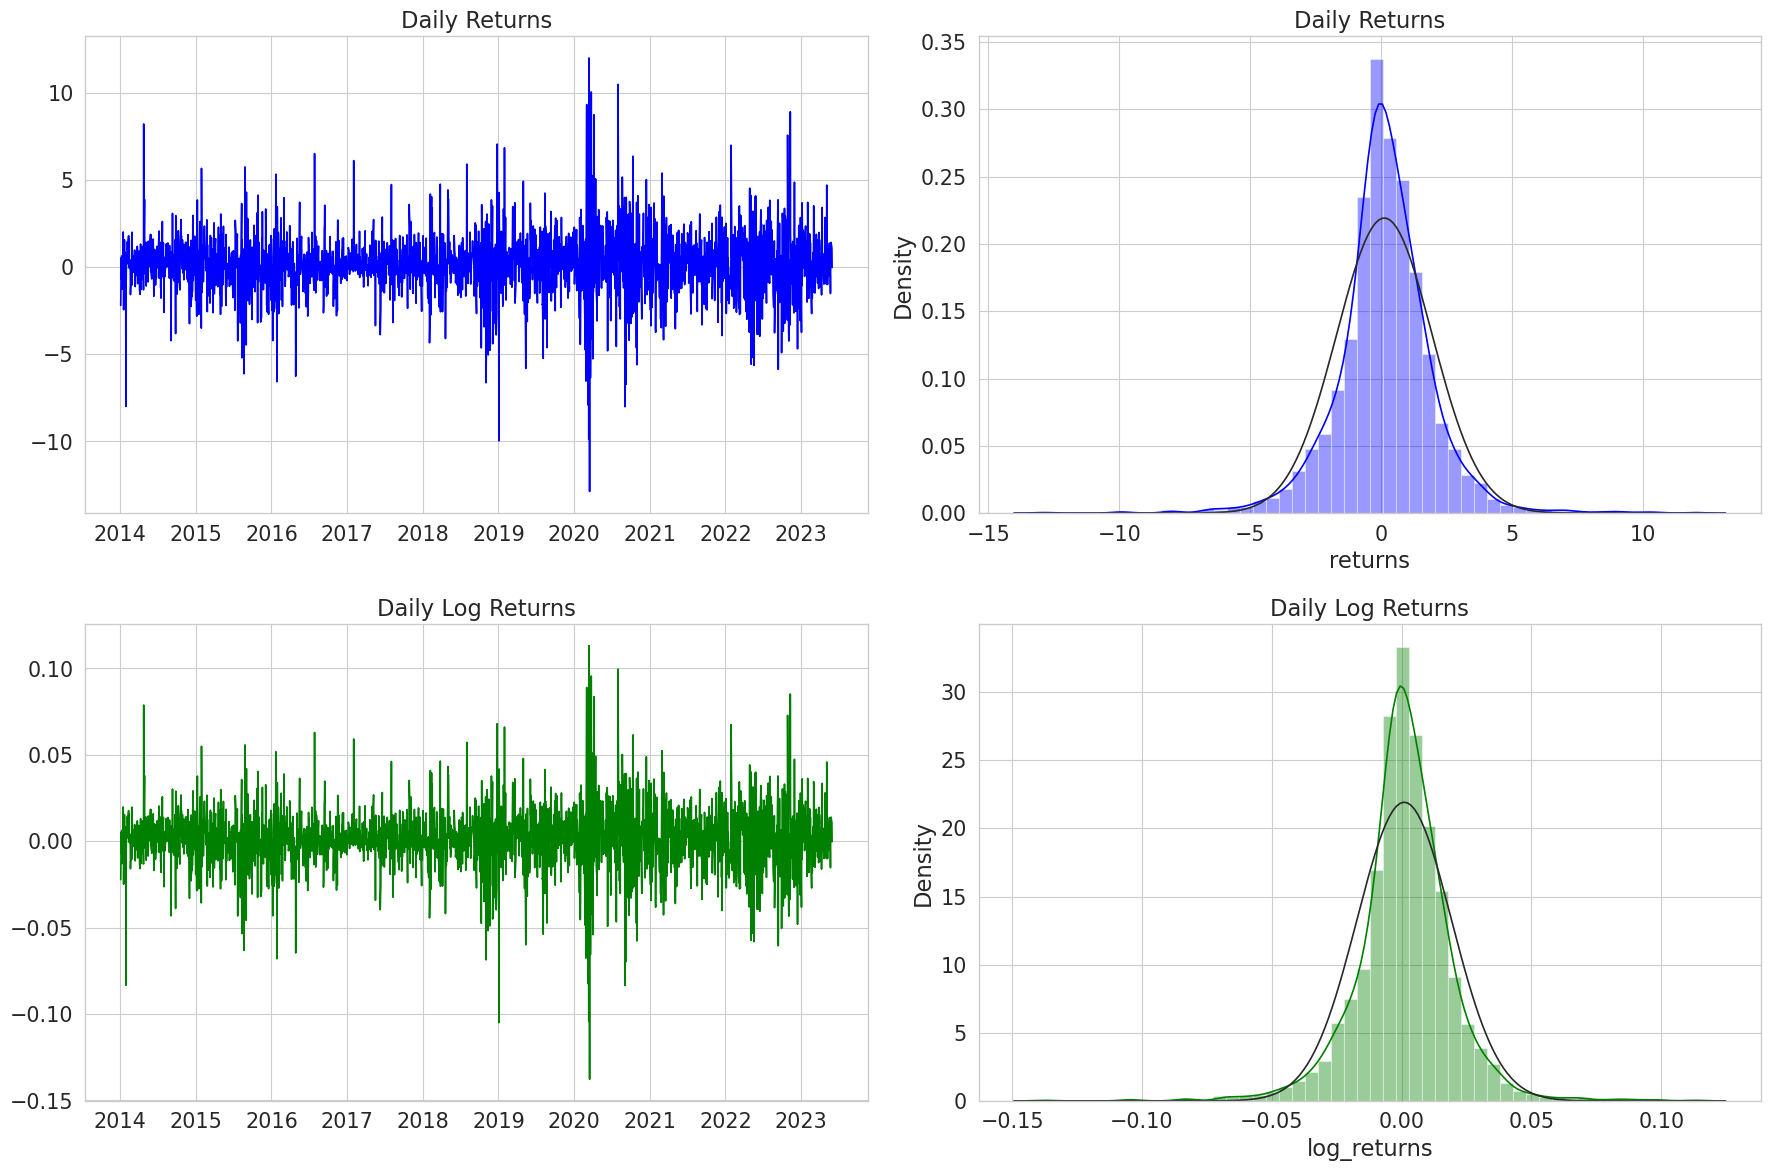

In [ ]:
#plot distribution plots of log returns
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Daily Returns')

    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Daily Returns')


    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Daily Log Returns')

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Daily Log Returns')
    plt.tight_layout()
    fig.show();

In [ ]:
df.log_returns.describe()

count    2368.000000
mean        0.000981
std         0.018203
min        -0.137708
25%        -0.007233
50%         0.000903
75%         0.010293
max         0.113158
Name: log_returns, dtype: float64

In [ ]:
#calculate the daily volatility
df['volatility'] = df.log_returns.abs()

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,returns,log_returns,volatility
count,2368.000000,2368.000000,2368.000000,2368.000000,2.368000e+03,2368.000000,2368.000000,2368.000000
mean,69.350586,70.140021,68.607415,69.409281,1.416086e+08,0.114710,0.000981,0.012673
std,51.471403,52.132832,50.856130,51.527112,8.400694e+07,1.819708,0.018203,0.013101
min,15.524712,15.723795,15.473609,15.668934,3.519590e+07,-12.864696,-0.137708,0.000000
25%,26.799410,27.068254,26.604446,26.898584,8.604020e+07,-0.720694,-0.007233,0.003881
50%,44.221497,44.523339,43.823038,44.228100,1.167480e+08,0.090326,0.000903,0.008777
75%,123.051826,124.621039,121.659694,123.378130,1.724382e+08,1.034573,0.010293,0.017259
max,180.804793,181.111693,177.329863,180.190948,1.065523e+09,11.980846,0.113158,0.137708


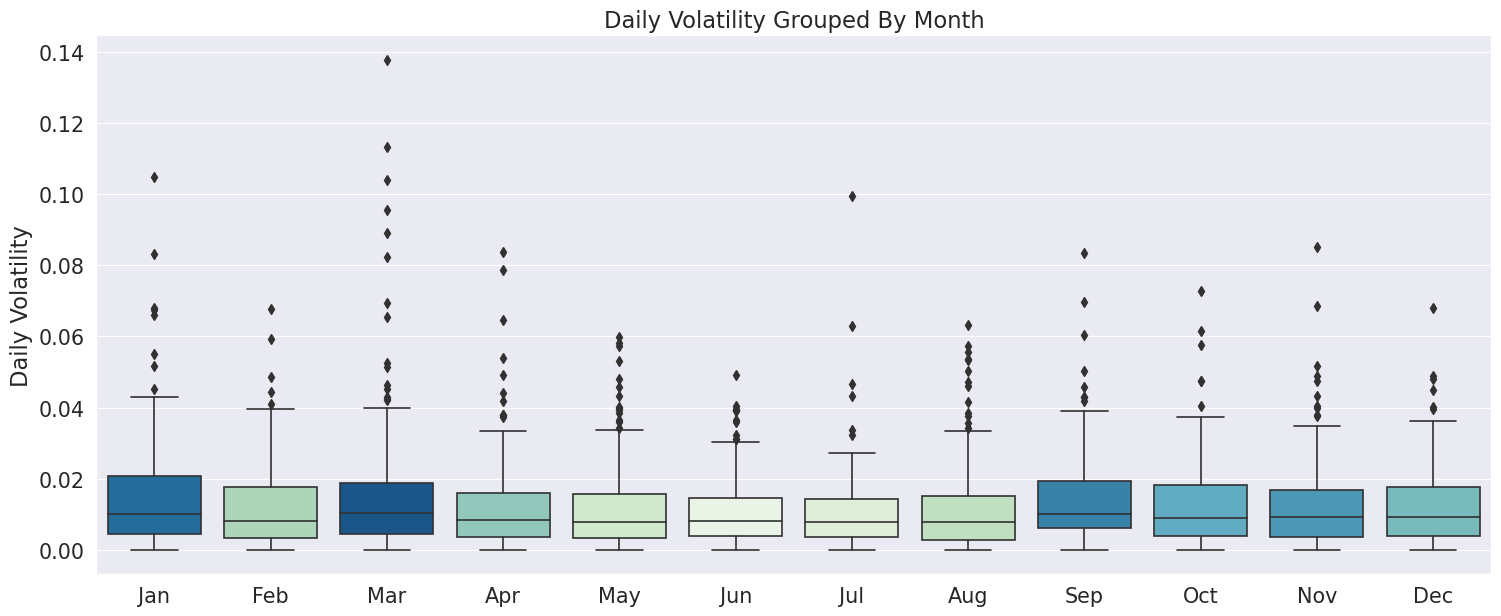

In [ ]:
# Daily volatility grouped by month

# PRESORT MONTHS IN CHRONOLOGICAL ORDER
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# GROUP vol_current BY MONTH AND TAKE THE MEAN
data = df.groupby(by=[df.index.month_name()])['volatility'].mean()

# ABBREVIATE MONTH NAME
data.index = [x[:3] for x in data.index]

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18, 7))

    sns.boxplot(x=[x[:3] for x in df.index.month_name()],
                y=df['volatility'],
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='',
           ylabel='Daily Volatility',
           title='Daily Volatility Grouped By Month')
    plt.show()

In [ ]:
val_size, test_size, train_size = split_dataset(df, validation_percentage, test_percentage)

In [ ]:
# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
n_train = df.index[:split_time_1]
n_validation = df.index[split_time_1:split_time_2]
n_test = df.index[split_time_2:]

In [ ]:
print(f'TRAINING \tFrom: {n_train[0]} \tto: {n_train[-1]} \t{len(n_train)} days')
print(f'VALIDATION \tFrom: {n_validation[0]} \tto: {n_validation[-1]} \t{len(n_validation)} days')
print(f'TEST \t\tFrom: {n_test[0]} \tto: {n_test[-1]} \t{len(n_test)} days')

TRAINING 	From: 2014-01-03 00:00:00-05:00 	to: 2020-08-05 00:00:00-04:00 	1659 days
VALIDATION 	From: 2020-08-06 00:00:00-04:00 	to: 2022-06-22 00:00:00-04:00 	473 days
TEST 		From: 2022-06-23 00:00:00-04:00 	to: 2023-05-31 00:00:00-04:00 	236 days


The `realized_volatility_daily` function calculates the daily realized volatility from the daily log returns of a time series. Realized volatility is a measure of the variability of actual observed returns within the specified period.

In [ ]:
def realized_volatility_daily(log_returns):
    """
    Calculate daily realized volatility, which is the square root of the sum of squared log returns.

    Parameters:
    log_returns (array-like): Array-like object containing the log returns.

    Returns:
    float: Daily realized volatility.
    """
    squared_returns = np.power(log_returns, 2)
    sum_squared_returns = np.sum(squared_returns)
    return np.sqrt(sum_squared_returns)

Let's calculate the realized volatility of the log returns over a rolling window `INTERVAL_WINDOW`.

By shifting the log returns by n_future days into the future and then calculating the realized volatility over the same rolling window `INTERVAL_WINDOW` for these shifted returns we get the future volatility. This gives you an estimate of the future realized volatility based on the shifted log returns and this is good for model estimation.

In [ ]:
# GET BACKWARD LOOKING REALIZED VOLATILITY
df['volatility_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY
df['volatility_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [ ]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS
# useful for baseline
x_train = df.volatility_current[n_train]
x_val = df.volatility_current[n_validation]
x_test = df.volatility_current[n_test]

In [ ]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS
# (this would be the target)
y_train = df.volatility_future[n_train]
y_val = df.volatility_future[n_validation]
y_test = df.volatility_future[n_test]

In [ ]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[n_train]
r_val = df.returns[n_validation]
r_test = df.returns[n_test]

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,returns,log_returns,volatility,volatility_current,volatility_future
count,2368.000000,2368.000000,2368.000000,2368.000000,2.368000e+03,2368.000000,2368.000000,2368.000000,2339.000000,2332.000000
mean,69.350586,70.140021,68.607415,69.409281,1.416086e+08,0.114710,0.000981,0.012673,0.091789,0.091748
std,51.471403,52.132832,50.856130,51.527112,8.400694e+07,1.819708,0.018203,0.013101,0.039635,0.039687
min,15.524712,15.723795,15.473609,15.668934,3.519590e+07,-12.864696,-0.137708,0.000000,0.028906,0.028906
25%,26.799410,27.068254,26.604446,26.898584,8.604020e+07,-0.720694,-0.007233,0.003881,0.066439,0.066413
50%,44.221497,44.523339,43.823038,44.228100,1.167480e+08,0.090326,0.000903,0.008777,0.082611,0.082402
75%,123.051826,124.621039,121.659694,123.378130,1.724382e+08,1.034573,0.010293,0.017259,0.105180,0.105101
max,180.804793,181.111693,177.329863,180.190948,1.065523e+09,11.980846,0.113158,0.137708,0.325303,0.325303


* In the GARCH modeling framework, it is generally recommended to work with standardized data rather than the raw data. This includes scaling the data before feeding it as input to the GARCH model. By scaling the data, you can ensure that the model treats each variable on a similar scale and avoids any potential issues arising from differences in magnitude.

In [ ]:
def transform_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [ ]:
# INITIATE SCALER
scaler = RobustScaler()

#ADDESTRAMENTO DELLO SCALER SU TRAIN_DATA
scaler = scaler.fit(x_train.values.reshape(-1,1))

In [ ]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES
x_train_scaled = transform_to_scaler(scaler, x_train)
y_train_scaled = transform_to_scaler(scaler, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_to_scaler(scaler, x_val)
y_val_scaled = transform_to_scaler(scaler, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_to_scaler(scaler, x_test)
y_test_scaled = transform_to_scaler(scaler, y_test)

In [ ]:
# Verifica gli indici dei dati di training
print("x_train_scaled index:", x_train_scaled.index)
print("y_train_scaled index:", y_train_scaled.index)

# Verifica gli indici dei dati di validazione
print("x_val_scaled index:", x_val_scaled.index)
print("y_val_scaled index:", y_val_scaled.index)

# Verifica gli indici dei dati di test
print("x_test_scaled index:", x_test_scaled.index)
print("y_test_scaled index:", y_test_scaled.index)

x_train_scaled index: DatetimeIndex(['2014-01-03 00:00:00-05:00', '2014-01-06 00:00:00-05:00',
               '2014-01-07 00:00:00-05:00', '2014-01-08 00:00:00-05:00',
               '2014-01-09 00:00:00-05:00', '2014-01-10 00:00:00-05:00',
               '2014-01-13 00:00:00-05:00', '2014-01-14 00:00:00-05:00',
               '2014-01-15 00:00:00-05:00', '2014-01-16 00:00:00-05:00',
               ...
               '2020-07-23 00:00:00-04:00', '2020-07-24 00:00:00-04:00',
               '2020-07-27 00:00:00-04:00', '2020-07-28 00:00:00-04:00',
               '2020-07-29 00:00:00-04:00', '2020-07-30 00:00:00-04:00',
               '2020-07-31 00:00:00-04:00', '2020-08-03 00:00:00-04:00',
               '2020-08-04 00:00:00-04:00', '2020-08-05 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=1659, freq=None)
y_train_scaled index: DatetimeIndex(['2014-01-03 00:00:00-05:00', '2014-01-06 00:00:00-05:00',
               '2014-01-07 00:00:00-05:0

In [ ]:
x_train_scaled = pd.Series(x_train_scaled)
x_val_scaled = pd.Series(x_val_scaled)

combined_x_scaled = pd.concat([x_train_scaled, x_val_scaled])

In [ ]:
#combine train dataset and validation dataset in a wider dataset

r_train = pd.Series(r_train)
r_val = pd.Series(r_val)
r_test = pd.Series(r_test)

combined_data = pd.concat([r_train, r_val])

In [ ]:
"""#prepare the entire returns dataset useful to make the prediction
returns_dataset = pd.concat([r_train, r_val, r_test])"""

'#prepare the entire returns dataset useful to make the prediction\nreturns_dataset = pd.concat([r_train, r_val, r_test])'

In [ ]:
combined_data.describe()

count    2132.000000
mean        0.112437
std         1.807934
min       -12.864696
25%        -0.680062
50%         0.094185
75%         1.025749
max        11.980846
Name: returns, dtype: float64

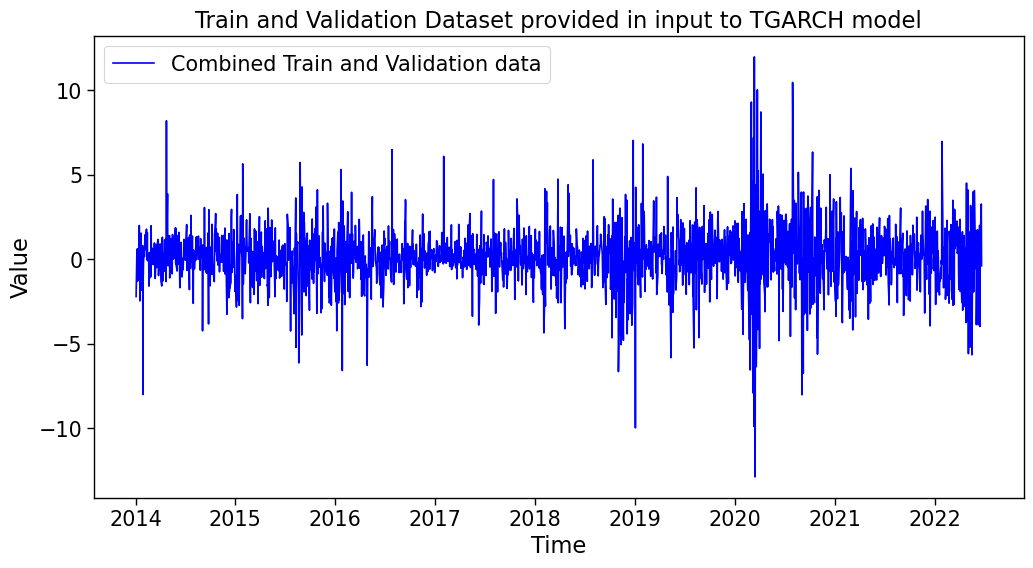

In [ ]:
# plot combined_data
plt.figure(figsize=(12, 6))
plt.plot(combined_data, color='blue', label='Combined Train and Validation data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Train and Validation Dataset provided in input to TGARCH model')
plt.show()

In [ ]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):

    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))

        plt.plot(y_true, color='blue', lw=2,
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

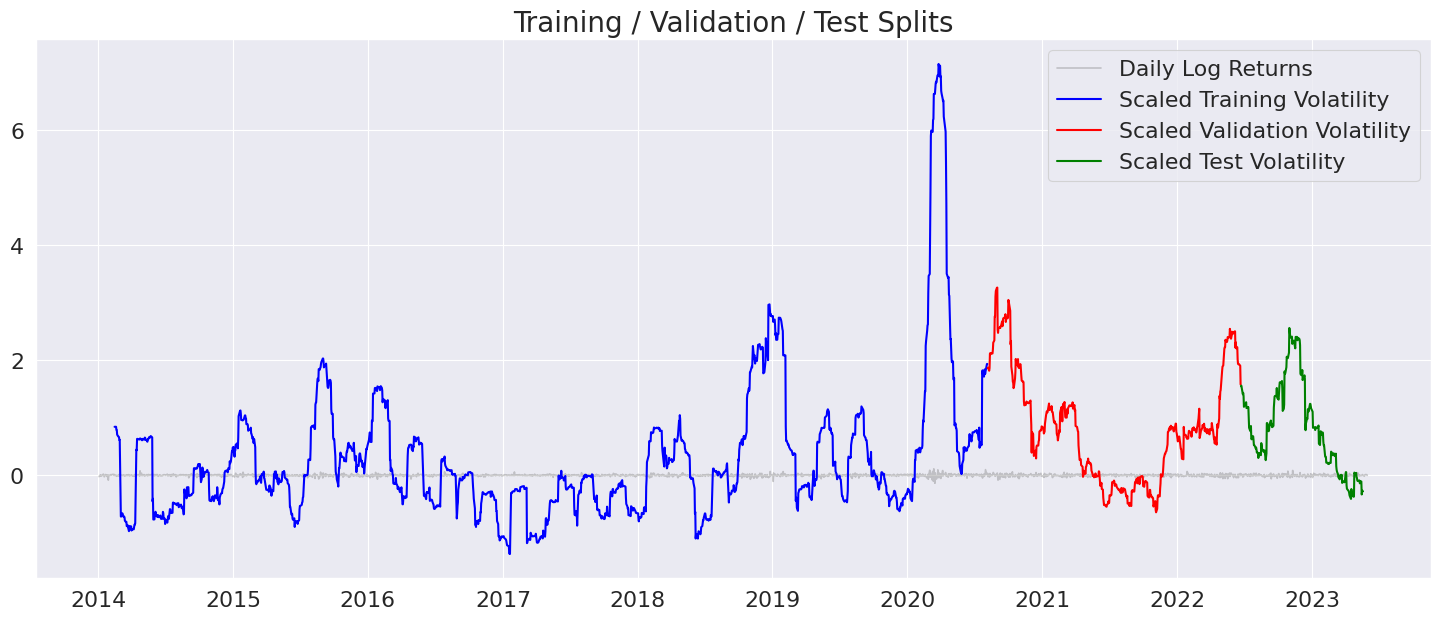

In [ ]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue',
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red',
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green',
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=20)
    plt.legend(frameon=True)
    plt.show();

#**Performance metrics**




In [ ]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / ((y_true + y_pred) / 2))))
    return output

In [ ]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [ ]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [ ]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = RobustScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [ ]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_performance(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name,
                                       RMSPE(y_true, y_pred),
                                       RMSE(y_true, y_pred)]
    return perf_df

#**Naive Forecasting**


The Naive forecasting method is a very simple forecasting technique that assumes the future value of a time series is equal to the last known value. In practice, to make a forecast for a certain point in the future, you take the most recent known value of the time series and repeat it for the entire forecast period.

In other words, this method doesn't analyze trends or patterns in the time series, but simply projects the most recent value forward. This approach is useful only when predicting a constant or rather stable trend in the data. It's important to note that the Naive method doesn't account for any patterns, seasonality, or external factors that could influence the time series.

In [ ]:
# Create Naive Forecast using the last known value
naive_forecast = np.repeat(x_val_scaled.iloc[-1], len(y_val_scaled))

In [ ]:
# Append the naive forecast to the DataFrame
log_performance(y_val_scaled, naive_forecast, 'Naive Forecasting (Last Value)')

,Model,Validation RMSPE,Validation RMSE
0,Naive Forecasting (Last Value),1.563338,1.680453


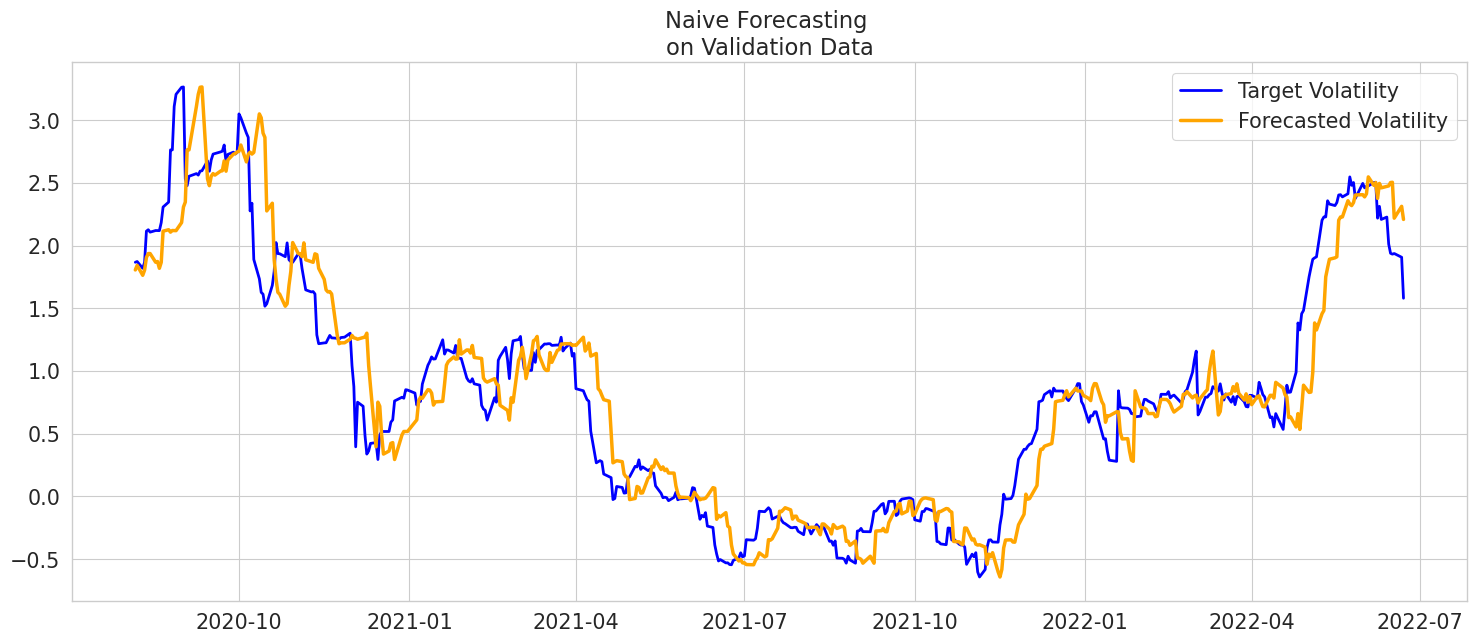

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, x_val_scaled, 'Naive Forecasting')
plt.show();

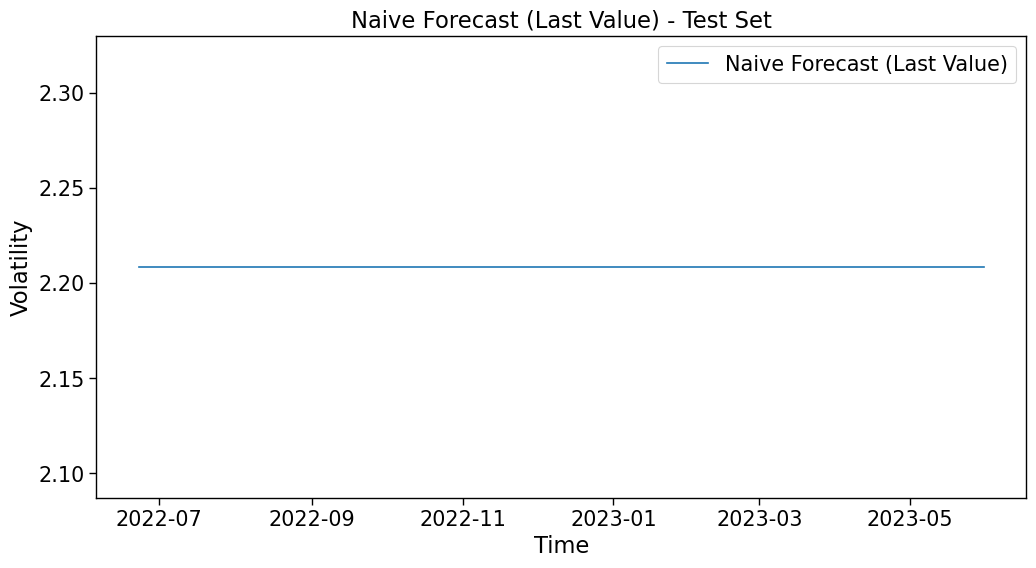

In [ ]:
# Create Naive Forecast using the last known value for the test set
naive_forecast_test = np.repeat(x_val_scaled.iloc[-1], len(y_test_scaled))

# Plotting the Naive Forecast on the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled.index, naive_forecast_test, label='Naive Forecast (Last Value)')
plt.legend()
plt.title("Naive Forecast (Last Value) - Test Set")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.show()

#**Random Walk With Drift**

In [ ]:
# Calculate the drift (average change in the series)
drift = x_train_scaled.diff().mean()
print(drift)

0.0005256132166318983


In [ ]:
# Create Random Walk with Drift Forecast using the last known value and drift
random_walk_drift_preds = x_val_scaled + drift

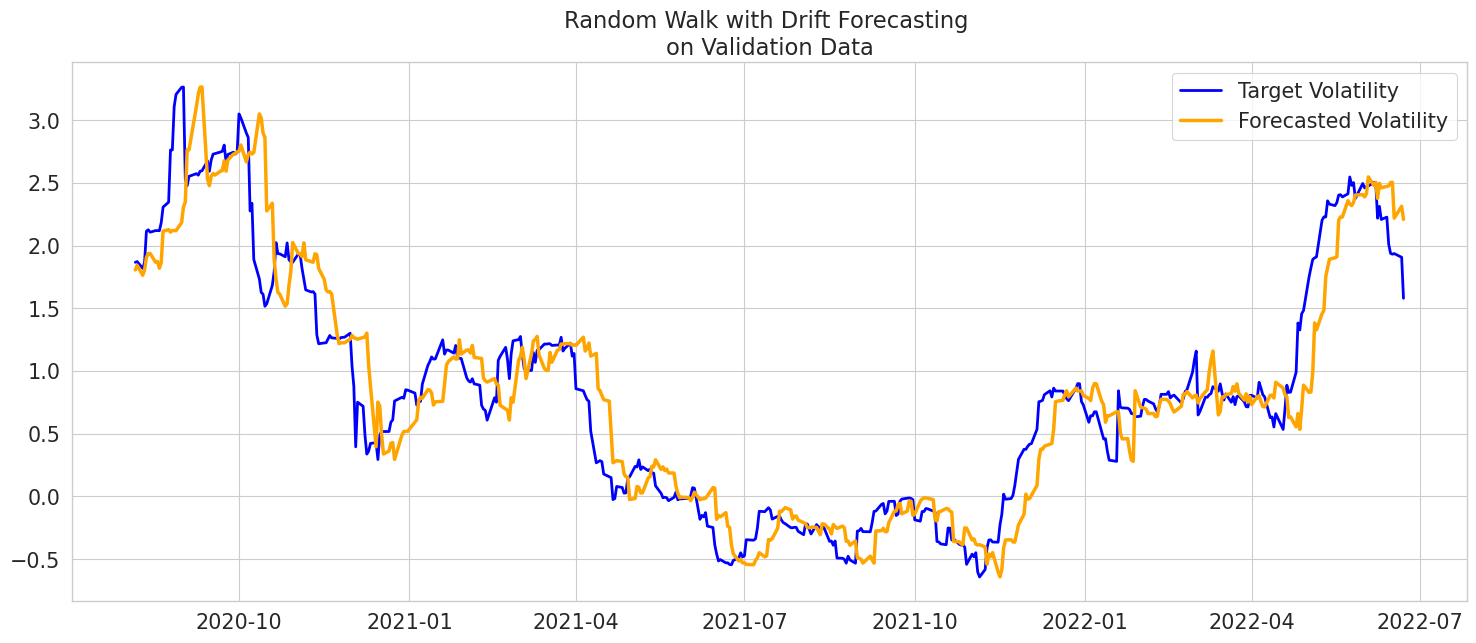

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_drift_preds, 'Random Walk with Drift Forecasting')
plt.show()

In [ ]:
# Append the random walk with drift forecast to the DataFrame
log_performance(y_val_scaled, random_walk_drift_preds, 'Random Walk with Drift Forecasting')

,Model,Validation RMSPE,Validation RMSE
0,Naive Forecasting (Last Value),1.563338,1.680453
1,Random Walk with Drift Forecasting,2.468260,0.329866


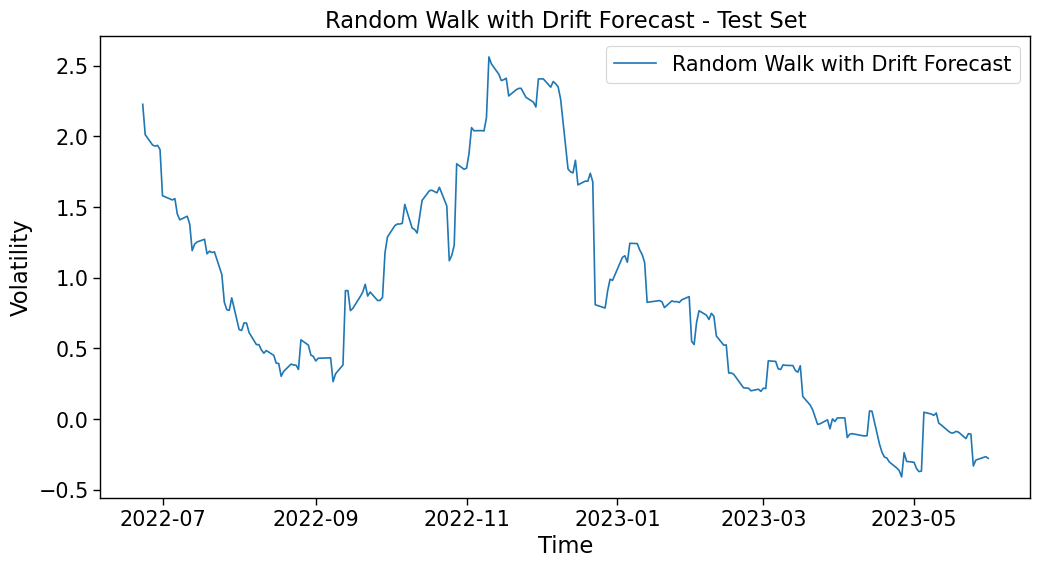

In [ ]:
# Calculate the drift (average change in the series)
drift = x_train_scaled.diff().mean()

# Create Random Walk with Drift Forecast using the last known value and drift for test set
random_walk_drift_test_preds = x_test_scaled + drift

# Plotting the Random Walk with Drift Forecast on the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled.index, random_walk_drift_test_preds, label='Random Walk with Drift Forecast')
plt.legend()
plt.title("Random Walk with Drift Forecast - Test Set")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.show()

#**ARIMA**

In [ ]:
p = 1  # AR order
d = 1  # I order
q = 1  # MA order

In [ ]:
# ARIMA TRAINING
arima_model = ARIMA(combined_data, order=(p, d, q))
arima_model_fit = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Predict using the ARIMA model
arima_forecast = arima_model_fit.predict(start=len(y_train_scaled), end=len(y_train_scaled) + len(y_val_scaled) - 1, dynamic=False)

In [ ]:
# Resetta l'indice dell'array arima_forecast
arima_forecast.reset_index(drop=True, inplace=True)

y_val_scaled_temp = y_val_scaled
# Resetta l'indice dell'array y_true
y_val_scaled_temp.reset_index(drop=True, inplace=True)

# Ora gli indici degli array sono droppati e si è in grado di calcolare le metriche di performance senza ottenere valori NaN

In [ ]:
# Calculate performance metric (log_rmse)
log_performance(y_val_scaled, arima_forecast, 'ARIMA Forecasting')

,Model,Validation RMSPE,Validation RMSE
0,Naive Forecasting (Last Value),1.563338,1.680453
1,Random Walk with Drift Forecasting,2.468260,0.329866
2,ARIMA Forecasting,10.442259,1.171320


In [ ]:
arima_forecast_scaled = transform_to_scaler(scaler, arima_forecast)

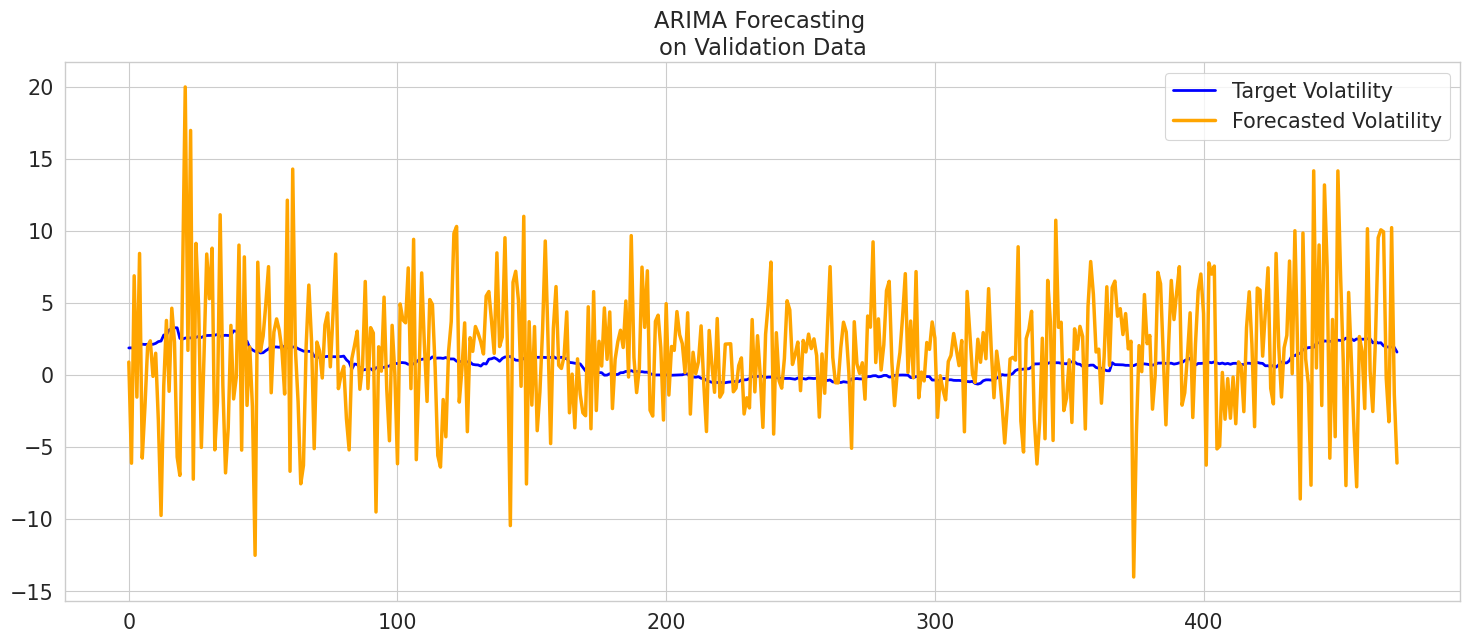

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, arima_forecast_scaled, 'ARIMA Forecasting')
plt.show()

#**Exponential Smoothing**

In [ ]:
# Train Exponential Smoothing model
ets_model = sm.tsa.ExponentialSmoothing(combined_data, seasonal='add', seasonal_periods=n_future).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Make forecasts using the ETS model with predict
ets_forecast = ets_model.predict(start=len(y_val_scaled), end=len(y_val_scaled)+len(y_val_scaled)-1)

In [ ]:
# Resetta l'indice dell'array arima_forecast
ets_forecast.reset_index(drop=True, inplace=True)

y_val_scaled_temp = y_val_scaled
# Resetta l'indice dell'array y_true
y_val_scaled_temp.reset_index(drop=True, inplace=True)

# Ora gli indici degli array sono droppati e si è in grado di calcolare le metriche di performance senza ottenere valori NaN

In [ ]:
# Calculate performance metric (log_rmse)
log_performance(y_val_scaled_temp, ets_forecast, 'Exponential Smoothing Forecasting')

,Model,Validation RMSPE,Validation RMSE
0,Naive Forecasting (Last Value),1.563338,1.680453
1,Random Walk with Drift Forecasting,2.468260,0.329866
2,ARIMA Forecasting,10.442259,1.171320
3,Exponential Smoothing Forecasting,18.179508,1.184411


In [ ]:
ets_forecast_scaled = transform_to_scaler(scaler, ets_forecast)

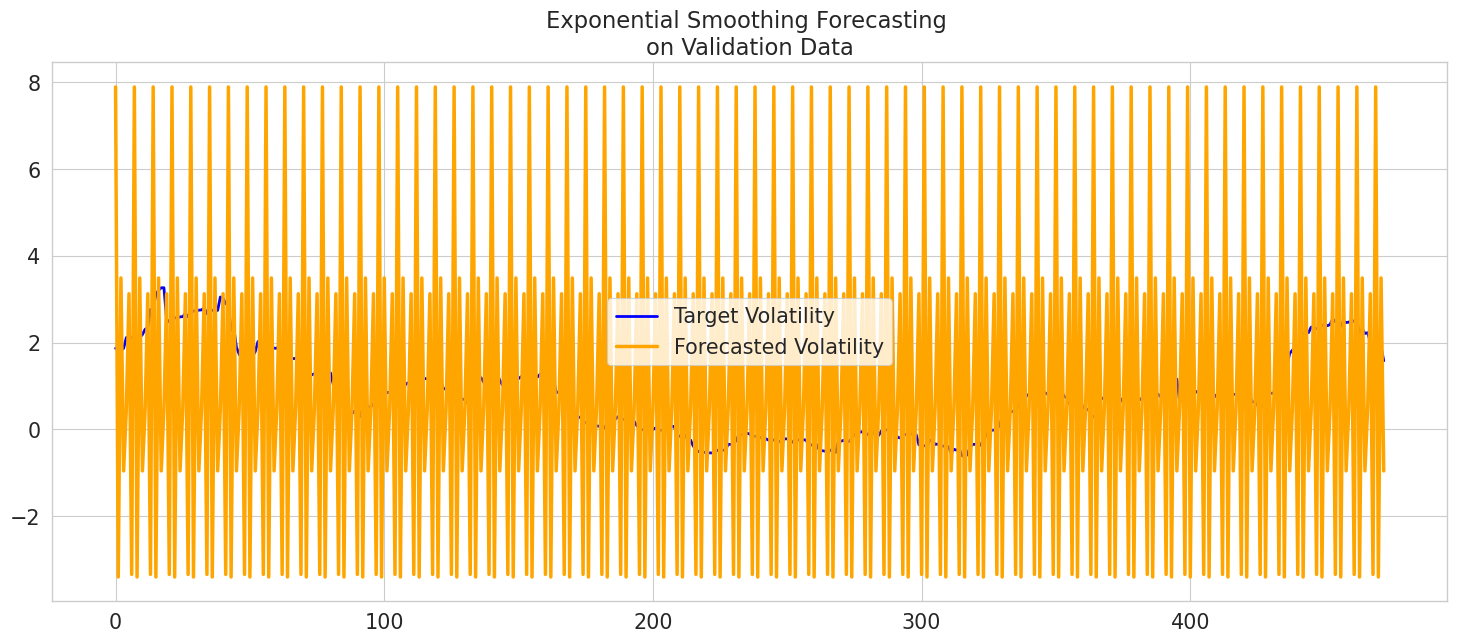

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, ets_forecast_scaled, 'Exponential Smoothing Forecasting')
plt.show()

#**TGARCH**

#TGARCH Hyperparameter optimization

In [ ]:
import arch
from arch import arch_model
import matplotlib.pyplot as plt

In [ ]:
def objective_int(trial):
    p = trial.suggest_int('p', 1, 5)
    o = trial.suggest_int('o', 0, 5)
    q = trial.suggest_int('q', 1, 5)

    model = arch_model(combined_data, p=p, o=o, q=q, power=2.0)
    model_fit = model.fit(disp='off')

    return model_fit.aic

In [ ]:
# Create two separate Optuna studies and optimize the objective functions
study_int = optuna.create_study(direction='minimize')

study_int.optimize(objective_int, n_trials=100)

[I 2023-10-24 13:10:31,071] A new study created in memory with name: no-name-adba66ab-b88d-4587-99f6-bd39653aff80
[I 2023-10-24 13:10:31,456] Trial 0 finished with value: 8084.6250720477165 and parameters: {'p': 5, 'o': 4, 'q': 3}. Best is trial 0 with value: 8084.6250720477165.
[I 2023-10-24 13:10:31,745] Trial 1 finished with value: 8144.472660917062 and parameters: {'p': 5, 'o': 0, 'q': 5}. Best is trial 0 with value: 8084.6250720477165.
[I 2023-10-24 13:10:31,972] Trial 2 finished with value: 8135.662349151586 and parameters: {'p': 1, 'o': 0, 'q': 2}. Best is trial 0 with value: 8084.6250720477165.
[I 2023-10-24 13:10:32,349] Trial 3 finished with value: 8087.804177751739 and parameters: {'p': 3, 'o': 4, 'q': 1}. Best is trial 0 with value: 8084.6250720477165.
[I 2023-10-24 13:10:33,021] Trial 4 finished with value: 8084.396477280829 and parameters: {'p': 4, 'o': 4, 'q': 4}. Best is trial 4 with value: 8084.396477280829.
[I 2023-10-24 13:10:33,648] Trial 5 finished with value: 8081

In [ ]:
# Get the best hyperparameters
best_params_int = study_int.best_params
print("Best integer hyperparameters:", best_params_int)

Best integer hyperparameters: {'p': 1, 'o': 2, 'q': 2}


#**Train the TGARCH predictor**

* In this case a TGARCH predictor is used.
* The process of estimating the GARCH model involves using the log returns as input to calculate the conditional volatility, which represents the estimated or forecasted volatility.
* The TGARCH model estimates the conditional volatility, which represents the expected level of volatility given past information.


In [ ]:
# Train the model with the best hyperparameters for both integer and float parameters
best_params_int = study_int.best_params

best_p_int = best_params_int['p']
best_o_int = best_params_int['o']
best_q_int = best_params_int['q']

best_model = arch_model(combined_data, p=best_p_int, o=best_o_int, q=best_q_int, power=2.0, dist='ged')
best_model_fit = best_model.fit(disp='off')

print()
print(best_model_fit.summary())


                         Constant Mean - GJR-GARCH Model Results                          
Dep. Variable:                            returns   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                              GJR-GARCH   Log-Likelihood:               -3940.50
Distribution:      Generalized Error Distribution   AIC:                           7897.00
Method:                        Maximum Likelihood   BIC:                           7942.32
                                                    No. Observations:                 2132
Date:                            Tue, Oct 24 2023   Df Residuals:                     2131
Time:                                    13:11:00   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
------------------------------

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(best_model_fit)

scaled_cond_vol.describe()

count    2132.000000
mean        0.292723
std         1.071845
min        -0.806684
25%        -0.402994
50%         0.000000
75%         0.597006
max        10.300491
dtype: float64

In [ ]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        #combined_x_scaled è la serie di dati di target
        ax.plot(combined_x_scaled, color='blue', lw=2,
                #variabile INTERVAL_WINDOW viene utilizzata per indicare la finestra temporale sulla quale è stata calcolata la volatilità realizzata
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();



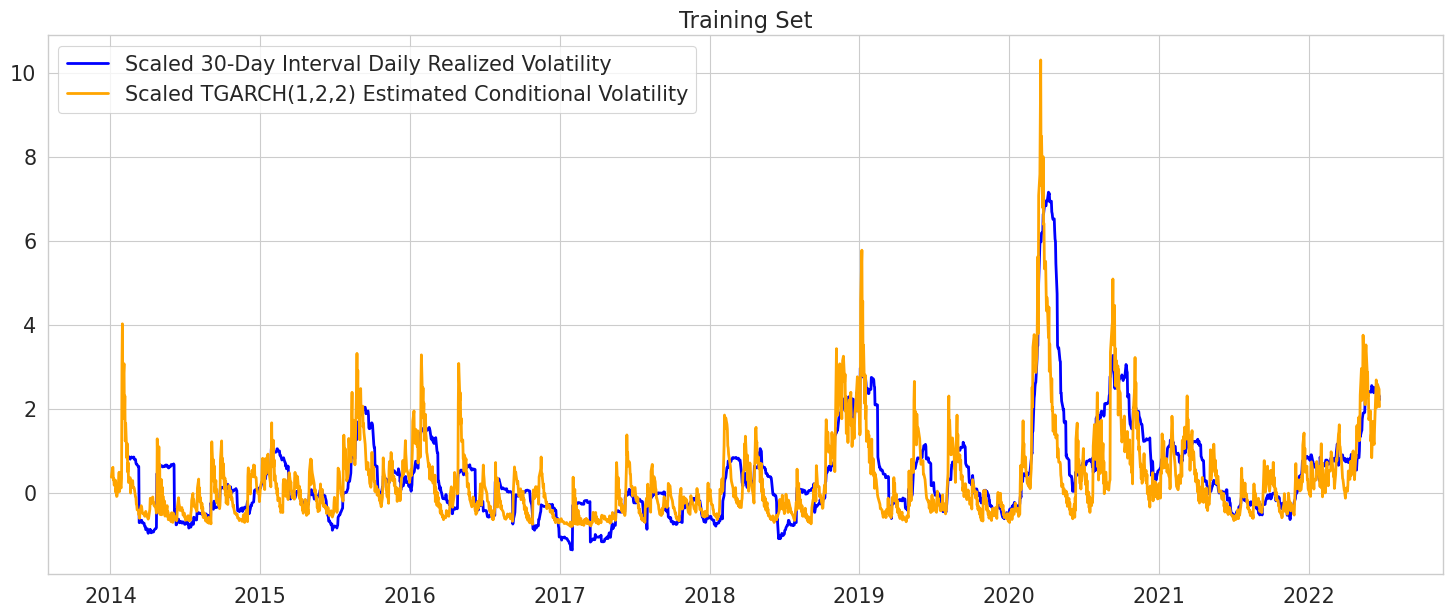

In [ ]:
viz_cond_vol(scaled_cond_vol, f'TGARCH({best_p_int},{best_o_int},{best_q_int})')

#**Generate the forecast: One-Step Expanding Window Forecast**

I am implementing a rolling one-step forecasting approach, where you refit your model using all the available data up to a certain time step and then generate predictions for the next `n_future` days. This is a common approach in time series forecasting, especially in cases where the data is non-stationary and the model needs to be updated with new information over time.

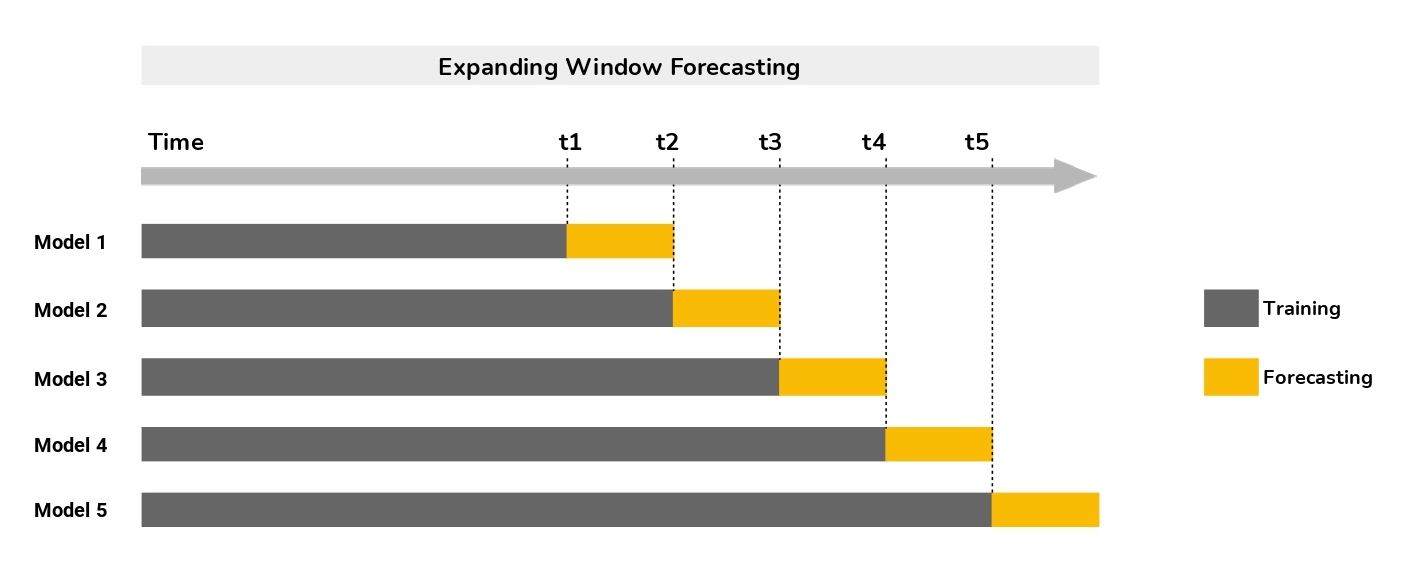

Firstly using the rolling window forecast, make a forecast on the Validation Dataset in order to calculate performance metrics

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(n_validation)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = n_validation[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=best_p_int, o=best_o_int, q=best_q_int, power=2.0,
                       dist='ged')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False,
                             ).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

tg_preds = pd.DataFrame(rolling_forecasts, index=n_validation)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
tg_preds_scaled = transform_to_scaler(scaler_garch, tg_preds)

In [ ]:
# Resetta l'indice dell'array arima_forecast
tg_preds_scaled.reset_index(drop=True, inplace=True)

# Resetta l'indice dell'array y_true
y_val_scaled.reset_index(drop=True, inplace=True)

# Ora gli indici degli array sono droppati e si è in grado di calcolare le metriche di performance senza ottenere valori NaN

In [ ]:
# Calculate performance metrics using the selected data
common_index = y_val_scaled.index.intersection(tg_preds_scaled.index)
tg_preds_val = tg_preds_scaled.loc[common_index]
y_val_selected = y_val_scaled.loc[common_index]

log_performance(y_val_selected, tg_preds_val, f'TGARCH({best_p_int},{best_o_int},{best_q_int})')

,Model,Validation RMSPE,Validation RMSE
0,Naive Forecasting (Last Value),1.563338,1.680453
1,Random Walk with Drift Forecasting,2.468260,0.329866
2,ARIMA Forecasting,10.442259,1.171320
3,Exponential Smoothing Forecasting,18.179508,1.184411
4,"TGARCH(1,2,2)",30.901122,0.709354


Then we can calculate the forecast on the Test Dataset

In [ ]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(n_test)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = n_test[i]
    train = df.returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=best_p_int, o=best_o_int, q=best_q_int, power=2.0,
                       dist='ged')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=n_test)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_to_scaler(scaler_garch, gm_1_preds)

In [ ]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_forecast(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        """plt.plot(x_test_scaled, color='gray',  ls=':',
               label=f"Scaled Current Daily Volatility")"""

        plt.plot(y_true, color='blue', lw=2,
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')

        plt.title(f'{model_name} \non Test Data')
        plt.legend(loc='best', frameon=True)

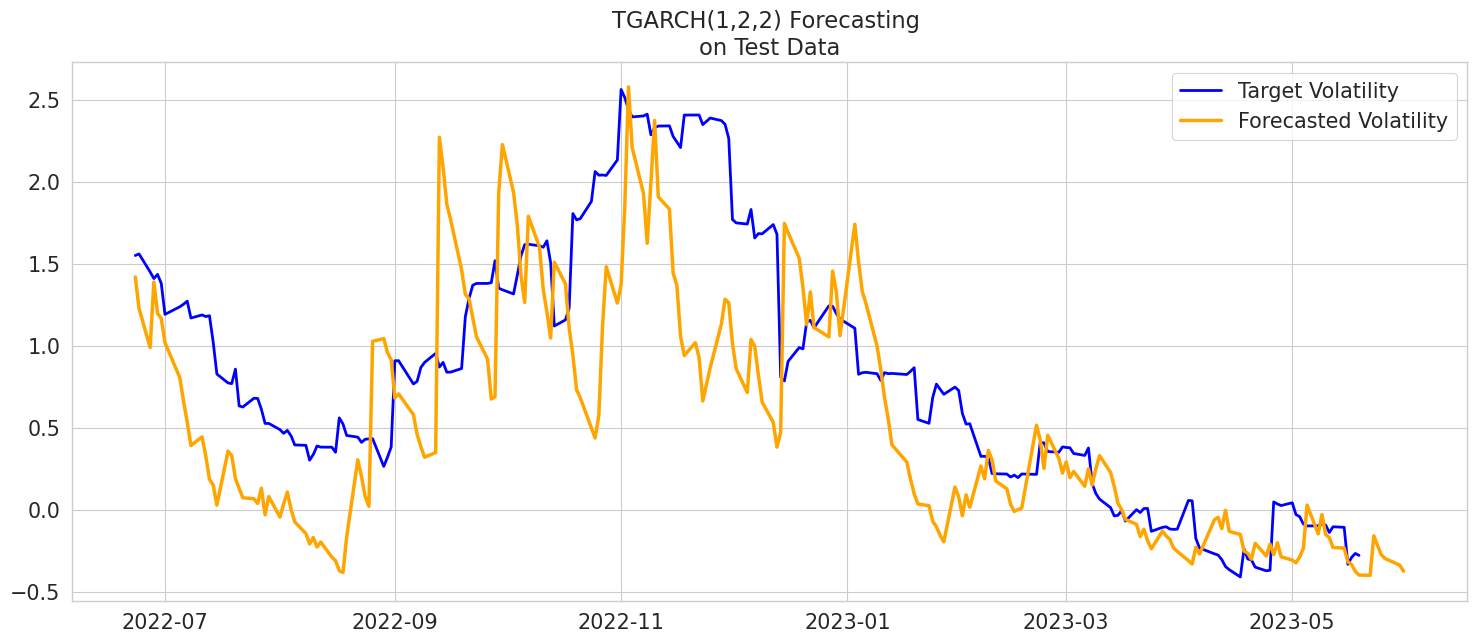

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_forecast(y_test_scaled, gm_1_preds_scaled,
          f'TGARCH({best_p_int},{best_o_int},{best_q_int}) Forecasting')

* **Scaled Current Daily Volatility**: This line represents the current daily volatility on the test set after applying scaling. The scaling is done using the same transformation that was applied to the forecasted volatility, ensuring a common comparison basis. This line shows the observed volatility in the test set, but made comparable with the forecast values.
* **Target Volatility**: This line represents the actual values of daily volatility in the test set. It is the real data on which the model made the forecast, without any scaling or manipulation.
* **Forecasted Volatility**: This line represents the model's forecast results. It is the volatility predicted by the model for the test period.

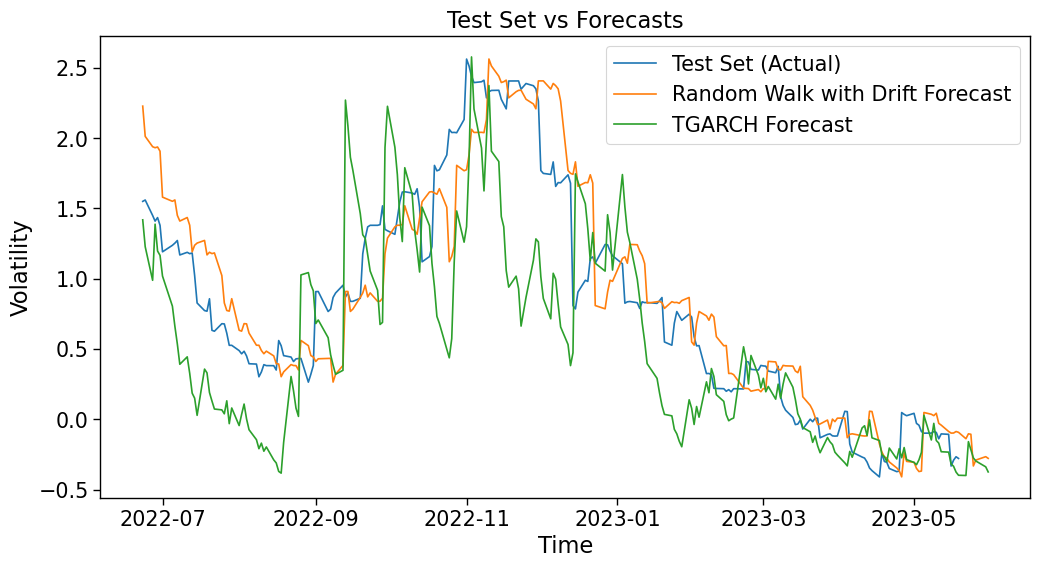

In [ ]:
# Plotting the test set, forecast, and TGARCH forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled.index, y_test_scaled, label='Test Set (Actual)')
plt.plot(y_test_scaled.index, random_walk_drift_test_preds, label='Random Walk with Drift Forecast')
plt.plot(y_test_scaled.index, gm_1_preds_scaled, label='TGARCH Forecast')
plt.legend()
plt.title("Test Set vs Forecasts")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.show()

#**Forecast on Test Dataset Performance Metrics**

Interpret the RMSE (Root Mean Squared Error):

* RMSE represents the square root of the average squared difference between the forecasted volatility and the actual volatility.
* A lower RMSE indicates better accuracy and closer alignment between the forecasted and actual volatility values.
* Compare the RMSE value to the scale of your data to assess its significance.

Interpret the MAE (Mean Absolute Error):

* MAE represents the average absolute difference between the forecasted volatility and the actual volatility.
* MAE provides a measure of the average magnitude of the forecast error, regardless of its direction.
* Compare the MAE value to the scale of your data to assess its significance.

Interpret RMPSE (Root Mean Percentage Squared Error):

* RMPSE calculates the average percentage error between the predicted values and the true values.
* A lower RMPSE indicates better accuracy, with a value of 0 indicating a perfect fit.
* The RMPSE value is usually presented as a percentage, making it easier to understand in terms of relative error.

In [ ]:
#Calculate metrics
def calculate_metrics(data):
    rmse = np.sqrt(np.mean((gm_1_preds_scaled - data['volatility_current'])**2))
    mae = np.mean(np.abs(gm_1_preds_scaled - data['volatility_current']))
    rmpse = np.sqrt(np.mean(np.square((gm_1_preds_scaled - data['volatility_current']) / data['volatility_current']))) * 100

    return rmse, mae, rmpse

In [ ]:
rmse, mae, rmpse = calculate_metrics(df)

In [ ]:
# Initialize an empty DataFrame
results_df = pd.DataFrame(columns=["Ticker", "RMSE", "MAE", "RMPSE"])

ticker_symbol = ticker.info["symbol"]

# Later in your code, append data to the DataFrame
results_df = results_df.append({"Ticker": ticker_symbol , "RMSE": rmse, "MAE": mae, "RMPSE": rmpse}, ignore_index=True)

# Save the DataFrame to a CSV file
results_df.to_csv(f"results_{ticker_symbol}.csv", index=False)


HTTPError: ignored

In [ ]:
print("RMSE:", rmse)
print("MAE:", mae)
print("RMPSE:", rmpse)

In [ ]:
 # Calculate the drift (average change in the series)
 drift = x_train_scaled.diff().mean()
 # Create Random Walk with Drift Forecast using the last known value and drift for test set
 random_walk_drift_test_preds = x_test_scaled + drift
print(drift)
random_walk_drift_test_preds.plot()

In [ ]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def performance(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name,
                                       RMSPE(y_true, y_pred),
                                       RMSE(y_true, y_pred)]
    return perf_df

In [ ]:
y_test_scaled.plot()

In [ ]:
def RMSPE(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

In [ ]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

In [ ]:
def performance(y_true, y_pred, model_name):
    # Create an empty DataFrame if perf_df doesn't exist
    if 'perf_df' not in globals():
        global perf_df
        perf_df = pd.DataFrame(columns=['Model', 'RMSPE', 'RMSE'])

    # Handling NaN values by dropping them
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true, y_pred = y_true[mask], y_pred[mask]

    rmspe_val = RMSPE(y_true, y_pred)
    rmse_val = RMSE(y_true, y_pred)

    perf_df.loc[len(perf_df)] = [model_name, rmspe_val, rmse_val]

    return perf_df

# Sample usage:
performance(y_test_scaled, random_walk_drift_test_preds, 'RWWD')